### Notebook to demonstrate downloading files for a selected ROI without VPN access

This only works for the `gs-chs-cmgp-dev account`, which has an IAM User with *read* access to all of the S3 buckets from *outside* the DOI network or PulseSecure VPN. (And *write* access only to the bucket named  

First, you need to have the IAM credentials in your hidden `.aws` folder. On Windows, this is usually `C:\User\username\.aws` and on Unix-like systems, a folder under your `HOME` directory, the one you get to with `cd ~`. 

There are two files in `.aws`, `config` and `credentials` that (hopefully) were created the first time you ran `aws configure`. The keys you gave it then are your default profile, and were associated with an IAM User. (Note: an IAM User is not an actual user, but a set of permissions). You can add additional profiles. I have three.

My `config` file looks like this:
```
[default]
region = us-west-2
output = json
[coastcam]
region = us-west-2
output = json
[updown]
region = us-west-2
output = json
```

...and my `credentials` file looks (kind of) like this:
```
[default]
aws_access_key_id = AK1**
aws_secret_access_key = biGlongEncrytionkEy
[coastcam]
aws_access_key_id = AK2**
aws_secret_access_key = diFferentKeY
[updown]
aws_access_key_id = AK3**
aws_secret_access_key = sTilLaNotHerKey
```

The credentials for the `s3-upload-download` IAM User are stored in a `Secret` named `cmgp-sfm-upload-download-access`. (The secret name does not have to match the IAM User name). I accessed the *awsconsole*, navigated to `Secrets`, clicked on the Secret name `cmgp-sfm-upload-download-access`, scrolled down to `Secret values`, clicked on the box `Retrieve secret value`, grabbed those keys, and pasted them into my `credentials` file. I declared that profile to be `updown`...again, does not need to match the IAM User or Secret name. I also added an entry in my `config` file, as shown above.

In [1]:
import os
import pandas as pd
import boto3
import matplotlib.pyplot as plt
%matplotlib inline

# bounding coords for all of Pea Island
latmin = 35.604
latmax = 35.775
lonmin = -75.54
lonmax = -75.44

# location of the navigation file
parent_dir = '.'
nav_file = os.path.join('.','2020-0928_ppk-photo-locations-mbase-GP153112.txt')
path = os.path.join(parent_dir,nav_file)

# how many rows to skip at top of nav file?
skiprows = 41

print(path)

.\.\2020-0928_ppk-photo-locations-mbase-GP153112.txt


### Read the nav file into pandas and locate images inside the bounding box

In [2]:
df = pd.read_csv(path, skiprows=skiprows, header=None, delim_whitespace=True,\
                names = ['image_name','easting','northing','elev','lat','lon','ell','one',\
                         'SDHeight','SDHoriz','UTCDate','UTCTime','UTCSeconds'])

#dfs[hort] will accumulate locations inside bounding box
dfs = df[ (df['lat']>=latmin) & (df['lat']<=latmax) & (df['lon']>=lonmin) & (df['lon']<=lonmax) ]
print("Found {} images.".format(len(dfs)))

# dfa[all] will accumulate all locations
dfa = df.copy()
print("{} images now in dfa".format(len(dfa)))
dfs

Found 1337 images.
16532 images now in dfa


,image_name,easting,northing,elev,lat,lon,ell,one,SDHeight,SDHoriz,UTCDate,UTCTime,UTCSeconds
1094,2020-0928-160624-DSC01285-N7251F.jpg,452275.656,3959107.331,307.771,35.774871,-75.528021,268.857,1,0.042,0.019,9/28/2020,16:06:25.004523,144385.004524
1095,2020-0928-160625-DSC01286-N7251F.jpg,452325.199,3959087.258,308.984,35.774692,-75.527471,270.071,1,0.042,0.019,9/28/2020,16:06:26.005509,144386.005509
1096,2020-0928-160626-DSC01287-N7251F.jpg,452373.778,3959065.970,310.612,35.774502,-75.526933,271.699,1,0.042,0.019,9/28/2020,16:06:27.004552,144387.004552
1097,2020-0928-160627-DSC01288-N7251F.jpg,452421.627,3959043.504,312.399,35.774302,-75.526402,273.486,1,0.042,0.019,9/28/2020,16:06:28.006463,144388.006463
1098,2020-0928-160628-DSC01289-N7251F.jpg,452468.348,3959019.583,314.177,35.774089,-75.525883,275.264,1,0.042,0.019,9/28/2020,16:06:29.008424,144389.008424
...,...,...,...,...,...,...,...,...,...,...,...,...,...
15664,2020-0928-213029-DSC05856-N7251F.jpg,452713.138,3958881.260,778.847,35.772853,-75.523167,739.936,1,0.017,0.011,9/28/2020,21:30:30.022610,163830.022610
15665,2020-0928-213030-DSC05857-N7251F.jpg,452687.025,3958937.706,778.814,35.773361,-75.523459,739.903,1,0.017,0.011,9/28/2020,21:30:31.026526,163831.026526
15666,2020-0928-213031-DSC05858-N7251F.jpg,452661.082,3958993.859,778.916,35.773866,-75.523750,740.005,1,0.017,0.011,9/28/2020,21:30:32.025437,163832.025437
15667,2020-0928-213032-DSC05859-N7251F.jpg,452635.111,3959050.212,779.150,35.774373,-75.524040,740.237,1,0.017,0.011,9/28/2020,21:30:33.028050,163833.028050


### Make a simple plot as a sanity check

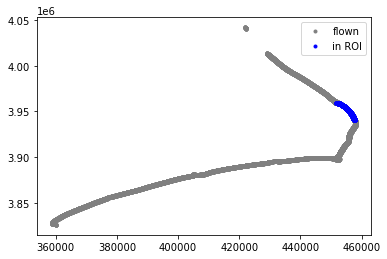

In [3]:
easting = dfa['easting'].values
northing = dfa['northing'].values
eastings = dfs['easting'].values
northings = dfs['northing'].values
plt.plot(easting,northing,'.',color='gray',label='flown')
plt.plot(eastings,northings,'.',color='blue',label='in ROI')
plt.legend()
plt.show()

### Use boto3 to set up a bucket object using the credentials in the `updown` profile

In [4]:
session = boto3.session.Session(profile_name='updown')
s3_resource = session.resource('s3')
bucket = s3_resource.Bucket('cmgp-sfm')

### Download four files

Note: To download all of the files, change the `for` loop to:  
        
`for f in dfs['image_name'].values :`

In [5]:
# location on S3
s3f = '2020-0928-NC/jpg_adobe/'

icount = 0
for f in dfs['image_name'].values[:4] :
    local_dest = os.path.join('.',f)
    try:
        src_key = s3f+f
        bucket.download_file(src_key, local_dest)
        print("Copied "+local_dest)
        icount = icount +1
    except:
        print("Fail: "+src_key)
           
print("Copied {} files.".format(icount))

Copied .\2020-0928-160624-DSC01285-N7251F.jpg
Copied .\2020-0928-160625-DSC01286-N7251F.jpg
Copied .\2020-0928-160626-DSC01287-N7251F.jpg
Copied .\2020-0928-160627-DSC01288-N7251F.jpg
Copied 4 files.
